# Advanced Image Processing and Text Recognition with Spark OCR

In [0]:
import os
import json
import string
import numpy as np
import pandas as pd


import sparknlp
import sparknlp_jsl
from sparknlp.base import *
from sparknlp.util import *
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *

from pyspark.sql import functions as F
from pyspark.ml import Pipeline, PipelineModel

pd.set_option('max_colwidth', 100)
pd.set_option('display.max_columns', 100)  
pd.set_option('display.expand_frame_repr', False)


print('sparknlp_jsl.version : ',sparknlp_jsl.version())

spark

sparknlp_jsl.version : 3.0.1
Out[1]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.0.1 
 Master 
 spark://10.164.242.43:7077 
 AppName 
 Databricks Shell

## Image (or Natural Scene) to Text

In [0]:
import base64
import sparkocr
from sparkocr.enums import *
from sparkocr.metrics import score
from sparkocr.transformers import *
from sparkocr.utils import display_image, to_pil_image
from sparkocr.databricks import display_images
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

spark.sql("set spark.sql.legacy.allowUntypedScalaUDF=true")

sys.path.append('/databricks/driver/')
sys.path.append('/databricks/driver/display_images.py')
sys.path.append('/databricks/driver/score.py')

# Pdf to Text

In [0]:
!wget -q -O sample_doc.pdf http://www.asx.com.au/asxpdf/20171103/pdf/43nyyw9r820c6r.pdf
dbutils.fs.cp("file:/databricks/driver/sample_doc.pdf", "dbfs:/")

Out[8]: True

In [0]:
def pipeline():
    
    # Transforrm PDF document to images per page
    pdf_to_image = PdfToImage()\
          .setInputCol("content")\
          .setOutputCol("image")

    # Run OCR
    ocr = ImageToText()\
          .setInputCol("image")\
          .setOutputCol("text")\
          .setConfidenceThreshold(65)
    
    pipeline = PipelineModel(stages=[
        pdf_to_image,
        ocr
    ])
    
    return pipeline

In [0]:
pdf = '/sample_doc.pdf'
pdf_example_df = spark.read.format("binaryFile").load(pdf).cache()

In [0]:
result = pipeline().transform(pdf_example_df).cache()

In [0]:
result.select("pagenum","text", "confidence").show()

+-------+--------------------+-----------------+
pagenum| text| confidence|
+-------+--------------------+-----------------+
 0|ASX ANNOUNCEMENT
...|89.30940204196506|
+-------+--------------------+-----------------+

In [0]:
result.select("text").collect()

Out[17]: [Row(text='ASX ANNOUNCEMENT\n3 November 2017\n\nNotice Pursuant to Paragraph 708A(5)(e) of the Corporations Act\n2001 ("Act")\n\nDigitalX Limited (ASX:DCC) (DCC or the Company) confirms that the Company has today\nissued 620,000 Fully Paid Ordinary Shares (Shares) upon exercise of 620,000 Unlisted\nOptions exercisable at $0.0324 Expiring 14 September 2019 and 3,725,000 Shares upon\nexercise of 3,725,000 Unlisted Incentive Options exercisable at $0.08 expiring 10 February\n2018.\n\nThe Act restricts the on-sale of securities issued without disclosure, unless the sale is exempt\nunder section 708 or 708A of the Act. By giving this notice, a sale of the Shares noted above\nwill fall within the exemption in section 708A(5) of the Act.\n\nThe Company hereby notifies ASX under paragraph 708A(5)(e) of the Act that:\n(a) the Company issued the Shares without disclosure to investors under Part 6D.2 of\nthe Act;\n(b) as at the date of this notice, the Company has complied with the provisions of Chapter\n2M of the Act as they apply to the Company, and section 674 of the Act; and\n(c) as at the date of this notice, there is no information:\na. — that has been excluded from a continuous disclosure notice in accordance with\nthe ASX Listing Rules; and\nb. — that investors and their professional advisers would reasonably require for the\npurpose of making an informed assessment of:\ni. the assets and liabilities, financial position and performance, profits and\nlosses and prospects of the Company; or\nii. the rights and liabilities attaching to the relevant Shares.\n\nDigitalX Limited\n\nLeigh Travers\nChief Executive Officer\nT: +61 439 376 847\n\nAbout DigitalX\n\nDigitalX is a Blockchain technology Company with offices in Perth and New York. DigitalX\nprovides Blockchain consulting services, ICO advisory services and software development.\nPartners can use DigitalX’s technology expertise to deliver innovative products to global\nmarkets.\n')]

In [0]:
print("\n".join([row.text for row in result.select("text").collect()]))


ASX ANNOUNCEMENT
3 November 2017

Notice Pursuant to Paragraph 708A(5)(e) of the Corporations Act
2001 ("Act")

DigitalX Limited (ASX:DCC) (DCC or the Company) confirms that the Company has today
issued 620,000 Fully Paid Ordinary Shares (Shares) upon exercise of 620,000 Unlisted
Options exercisable at $0.0324 Expiring 14 September 2019 and 3,725,000 Shares upon
exercise of 3,725,000 Unlisted Incentive Options exercisable at $0.08 expiring 10 February
2018.

The Act restricts the on-sale of securities issued without disclosure, unless the sale is exempt
under section 708 or 708A of the Act. By giving this notice, a sale of the Shares noted above
will fall within the exemption in section 708A(5) of the Act.

The Company hereby notifies ASX under paragraph 708A(5)(e) of the Act that:
(a) the Company issued the Shares without disclosure to investors under Part 6D.2 of
the Act;
(b) as at the date of this notice, the Company has complied with the provisions of Chapter
2M of the Act as they apply to the Company, and section 674 of the Act; and
(c) as at the date of this notice, there is no information:
a. — that has been excluded from a continuous disclosure notice in accordance with
the ASX Listing Rules; and
b. — that investors and their professional advisers would reasonably require for the
purpose of making an informed assessment of:
i. the assets and liabilities, financial position and performance, profits and
losses and prospects of the Company; or
ii. the rights and liabilities attaching to the relevant Shares.

DigitalX Limited

Leigh Travers
Chief Executive Officer
T: +61 439 376 847

About DigitalX

DigitalX is a Blockchain technology Company with offices in Perth and New York. DigitalX
provides Blockchain consulting services, ICO advisory services and software development.
Partners can use DigitalX’s technology expertise to deliver innovative products to global
markets.

##  With Skew Correction

In [0]:
from sparkocr.transformers import *
from pyspark.ml import PipelineModel
from sparkocr.utils import display_image
from sparkocr.metrics import score

In [0]:
def ocr_pipeline(skew_correction=False):
    
    # Transforrm PDF document to images per page
    pdf_to_image = PdfToImage()\
          .setInputCol("content")\
          .setOutputCol("image")

    # Image skew corrector 
    skew_corrector = ImageSkewCorrector()\
          .setInputCol("image")\
          .setOutputCol("corrected_image")\
          .setAutomaticSkewCorrection(skew_correction)

    # Run OCR
    ocr = ImageToText()\
          .setInputCol("corrected_image")\
          .setOutputCol("text")
    
    pipeline = PipelineModel(stages=[
        pdf_to_image,
        skew_corrector,
        ocr
    ])
    
    return pipeline

In [0]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/ocr/400_rot.pdf
dbutils.fs.cp("file:/databricks/driver/400_rot.pdf", "dbfs:/")

Out[21]: True

In [0]:
pdf_rotated_df = spark.read.format("binaryFile").load('/400_rot.pdf').cache()

In [0]:
pdf_pipeline = ocr_pipeline(False) 

result = pdf_pipeline.transform(pdf_rotated_df).cache()


In [0]:
result.show()

+-----------------+-------------------+-------+--------------------+-----------+-------+-----------+--------------------+-----------------+---------+--------------------+--------------------+
 path| modificationTime| length| image|total_pages|pagenum|documentnum| corrected_image| confidence|exception| text| positions|
+-----------------+-------------------+-------+--------------------+-----------+-------+-----------+--------------------+-----------------+---------+--------------------+--------------------+
dbfs:/400_rot.pdf|2021-05-03 19:47:27|2240141|[dbfs:/400_rot.pd...| 1| 0| 0|[dbfs:/400_rot.pd...|95.88622707790799| |FOREWORD

Electro...|[[[[FOREWORD

, 0...|
+-----------------+-------------------+-------+--------------------+-----------+-------+-----------+--------------------+-----------------+---------+--------------------+--------------------+

In [0]:
result.select("pagenum").collect()[0].pagenum

Out[26]: 0

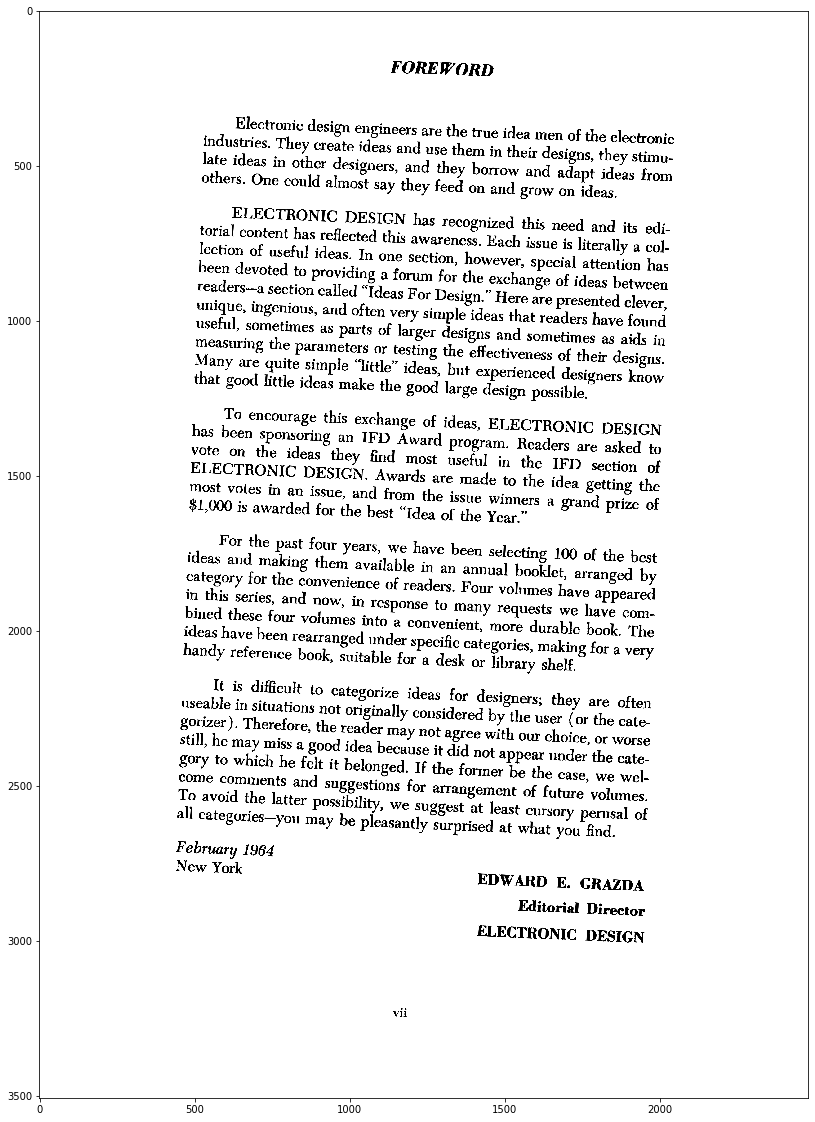

In [0]:
img = result.select("image").collect()[0].image
img_pil = to_pil_image(img, img.mode)

plt.figure(figsize=(30,20))
plt.imshow(img_pil, cmap='gray')
plt.show()

## Display recognized text without skew correction

In [0]:
result.select("pagenum","text", "confidence").show()


+-------+--------------------+-----------------+
pagenum| text| confidence|
+-------+--------------------+-----------------+
 0|FOREWORD

Electro...|95.88622707790799|
+-------+--------------------+-----------------+

In [0]:
print("\n".join([row.text for row in result.select("text").collect()]))

FOREWORD

Electronic design engineers are the true idea men of the electronic
industries. They create ideas and use them in their designs, they stimu-
late ideas in other designers, and they borrow and adapt ideas from
others. One could almost say they feed on and grow on ideas.

ELECTRONIC DESIGN has recognized this need and its edi-
torial content has reflected this awareness. Each issue is literally a col-

most votes in an issue, and from the issue winners a grand prize of
$1,000 is awarded for the best “Idea of the Year.”

For the past four years, we have been selecting 100 of the best
ideas and making them available in an annual booklet, arranged by

It is difficult to categorize ideas for designers; they are often
useable in situations not originally considered by the user (or the cate-

come comments and suggestions for arrangement of future volumes.
To avoid the latter possibility, we suggest at least cursory perusal of
all categories—you may be pleasantly surprised at what you find.

February 1964
New York EDWARD E. GRAZDA
Editorial Director

ELECTRONIC DESIGN

## Display results with skew correction

In [0]:
pdf_pipeline = ocr_pipeline(True) 

corrected_result = pdf_pipeline.transform(pdf_rotated_df).cache()

print("\n".join([row.text for row in corrected_result.select("text").collect()]))


FOREWORD

Electronic design engineers are the true idea men of the electronic
industries. They create ideas and use them in their designs, they stimu-
late ideas in other designers, and they borrow and adapt ideas from
others. One could almost say they feed on and grow on ideas.

ELECTRONIC DESIGN has recognized this need and its edi-
torial content has reflected this awareness. Each issue is literally a col-
lection of useful ideas. In one section, however, special attention has
been devoted to providing a forum for the exchange of ideas between
readers—a section called “Ideas For Design.” Here are presented clever,
unique, ingenious, and often very simple ideas that readers have found
useful, sometimes as parts of larger designs and sometimes as aids in
measuring the parameters or testing the effectiveness of their designs.
Many are quite simple “little” ideas, but experienced designers know
that good little ideas make the good large design possible.

To encourage this exchange of ideas, ELECTRONIC DESIGN
has been sponsoring an IFD Award program. Readers are asked to
vote on the ideas they find most useful in the IFD section of
ELECTRONIC DESIGN. Awards are made to the idea getting the
most votes in an issue, and from the issue winners a grand prize of
$1,000 is awarded for the best “Idea of the Year.”

For the past four years, we have been selecting 100 of the best
ideas and making them available in an annual booklet, arranged by
category for the convenience of readers. Four volumes have appeared
in this series, and now, in response to many requests we have com-
bined these four volumes into a convenient, more durable book. The
ideas have been rearranged under specific categories, making for a very
handy reference book, suitable for a desk or library shelf.

It is difficult to categorize ideas for designers; they are often
useable in situations not originally considered by the user (or the cate-
gorizer ). Therefore, the reader may not agree with our choice, or worse
still, he may miss a good idea because it did not appear under the cate-
gory to which he felt it belonged. If the former be the case, we wel-
come comments and suggestions for arrangement of future volumes.
To avoid the latter possibility, we suggest at least cursory perusal of
all categories—you may be pleasantly surprised at what you find.

February 1964
New York EDWARD E. GRAZDA
Editorial Director

ELECTRONIC DESIGN

In [0]:
corrected_result.select("pagenum","text", "confidence").show(truncate=50)


+-------+--------------------------------------------------+-----------------+
pagenum| text| confidence|
+-------+--------------------------------------------------+-----------------+
 0|FOREWORD

Electronic design engineers are the t...|96.03673458099365|
+-------+--------------------------------------------------+-----------------+

## Display skew corrected images

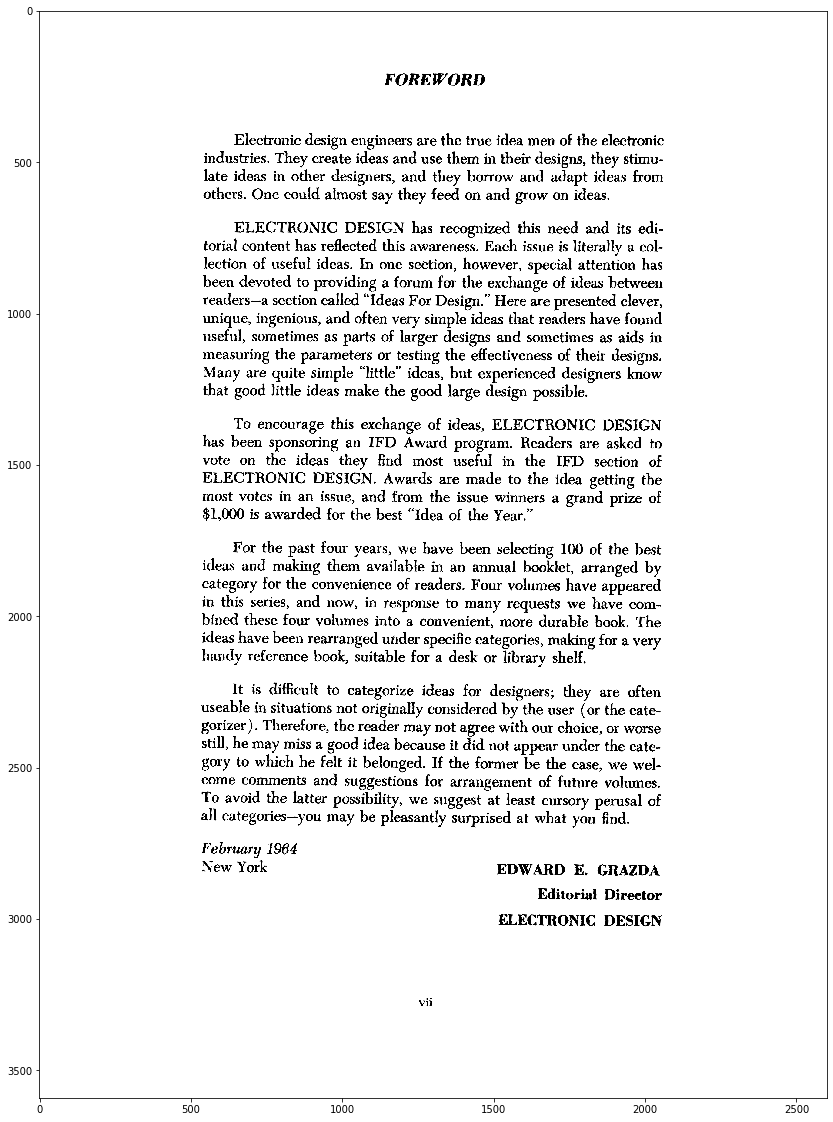

In [0]:
img = corrected_result.select("corrected_image").collect()[0].corrected_image
img_pil = to_pil_image(img, img.mode)

plt.figure(figsize=(30,20))
plt.imshow(img_pil, cmap='gray')
plt.show()

## Compute score and compare
Read original text and calculate scores for both results.

In [0]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/ocr/400.txt
dbutils.fs.cp("file:/databricks/driver/400.txt", "dbfs:/")

Out[46]: True

In [0]:
detected = "\n".join([row.text for row in result.collect()])
corrected_detected = "\n".join([row.text for row in corrected_result.collect()])

# read original text
pdf_rotated_text = open('400.txt', "r").read()

# compute scores
detected_score = score(pdf_rotated_text, detected)
corrected_score = score(pdf_rotated_text, corrected_detected)

#  print scores
print("Score without skew correction: {0}".format(detected_score))
print("Score with skew correction: {0}".format(corrected_score))

Score without skew correction: 0.5780748663101604
Score with skew correction: 0.9535615899252263

## Reading multiple pdfs from folder

In [0]:
pdf_path = "/*.pdf"

pdfs = spark.read.format("binaryFile").load(pdf_path).cache()
#images = spark.read.format("binaryFile").load('text_with_noise.png').cache()

pdfs.count()

Out[48]: 5

In [0]:
# Transforrm PDF document to images per page
pdf_to_image = PdfToImage()\
      .setInputCol("content")\
      .setOutputCol("image")

# Run OCR
ocr = ImageToText()\
      .setInputCol("image")\
      .setOutputCol("text")\
      .setConfidenceThreshold(65)\
      .setIgnoreResolution(False)

ocr_pipeline = PipelineModel(stages=[
    pdf_to_image,
    ocr
])


In [0]:
results = ocr_pipeline.transform(pdfs)


In [0]:
results.columns

Out[51]: ['path',
 'modificationTime',
 'length',
 'image',
 'total_pages',
 'pagenum',
 'documentnum',
 'confidence',
 'exception',
 'text',
 'positions']

In [0]:
results.select('path','confidence','text').show()

+--------------------+-----------------+--------------------+
 path| confidence| text|
+--------------------+-----------------+--------------------+
 dbfs:/400_rot.pdf|95.71951103210449|FOREWORD

Electro...|
 dbfs:/noised.pdf|69.65582870483398| 

 

 

Sample s...|
dbfs:/test_docume...| 81.2276874118381|Patient Nam
Finan...|
dbfs:/test_docume...|78.99487520300823|Patient Name
Fina...|
dbfs:/sample_doc.pdf|90.42361619737413|ASX ANNOUNCEMENT
...|
dbfs:/sample_pdf_...|90.42361619737413|ASX ANNOUNCEMENT
...|
+--------------------+-----------------+--------------------+

## Image processing after reading a pdf

In [0]:
from sparkocr.enums import *

# Read binary as image
pdf_to_image = PdfToImage()\
  .setInputCol("content")\
  .setOutputCol("image")\
  .setResolution(400)

# Binarize using adaptive tresholding
binarizer = ImageAdaptiveThresholding()\
  .setInputCol("image")\
  .setOutputCol("binarized_image")\
  .setBlockSize(91)\
  .setOffset(50)

# Apply morphology opening
opening = ImageMorphologyOperation()\
  .setKernelShape(KernelShape.SQUARE)\
  .setOperation(MorphologyOperationType.OPENING)\
  .setKernelSize(3)\
  .setInputCol("binarized_image")\
  .setOutputCol("opening_image")

# Remove small objects
remove_objects = ImageRemoveObjects()\
  .setInputCol("opening_image")\
  .setOutputCol("corrected_image")\
  .setMinSizeObject(130)

# Image Layout Analyzer for detect regions
image_layout_analyzer = ImageLayoutAnalyzer()\
  .setInputCol("corrected_image")\
  .setOutputCol("region")\

draw_regions = ImageDrawRegions()\
  .setInputCol("corrected_image")\
  .setInputRegionsCol("region")\
  .setOutputCol("image_with_regions")

# Run tesseract OCR for corrected image
ocr_corrected = ImageToText()\
  .setInputCol("corrected_image")\
  .setOutputCol("corrected_text")\
  .setPositionsCol("corrected_positions")\
  .setConfidenceThreshold(65)

# Run OCR for original image
ocr = ImageToText()\
  .setInputCol("image")\
  .setOutputCol("text")

# OCR pipeline
image_pipeline = PipelineModel(stages=[
    pdf_to_image,
    binarizer,
    opening,
    remove_objects,
    image_layout_analyzer,
    draw_regions,
    ocr,
    ocr_corrected
])

In [0]:
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/pdfs/noised.pdf
dbutils.fs.cp("file:/databricks/driver/noised.pdf", "dbfs:/")

Out[54]: True

In [0]:
image_df = spark.read.format("binaryFile").load('/noised.pdf').cache()
image_df.show()

+----------------+-------------------+-------+--------------------+
 path| modificationTime| length| content|
+----------------+-------------------+-------+--------------------+
dbfs:/noised.pdf|2021-05-03 20:13:28|2115939|[25 50 44 46 2D 3...|
+----------------+-------------------+-------+--------------------+

In [0]:
result = image_pipeline.transform(image_df).cache()

Original: dbfs:/noised.pdf
Corrected: dbfs:/noised.pdf

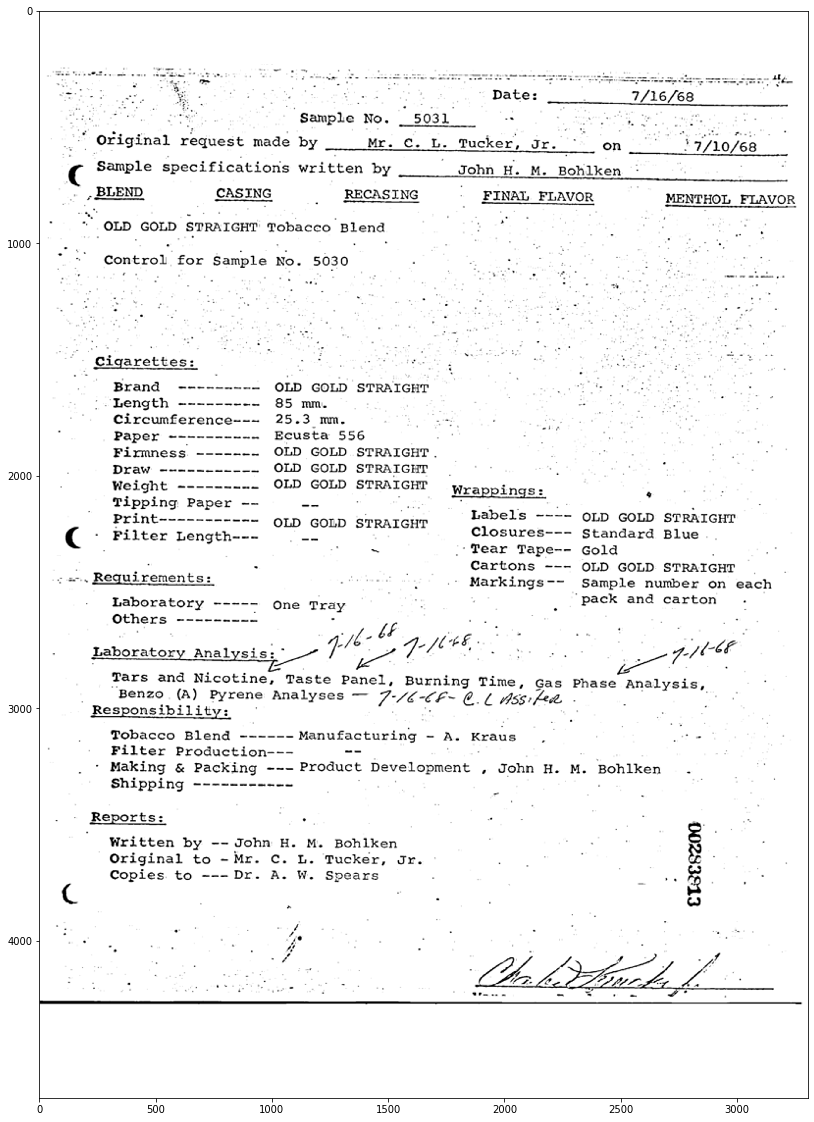

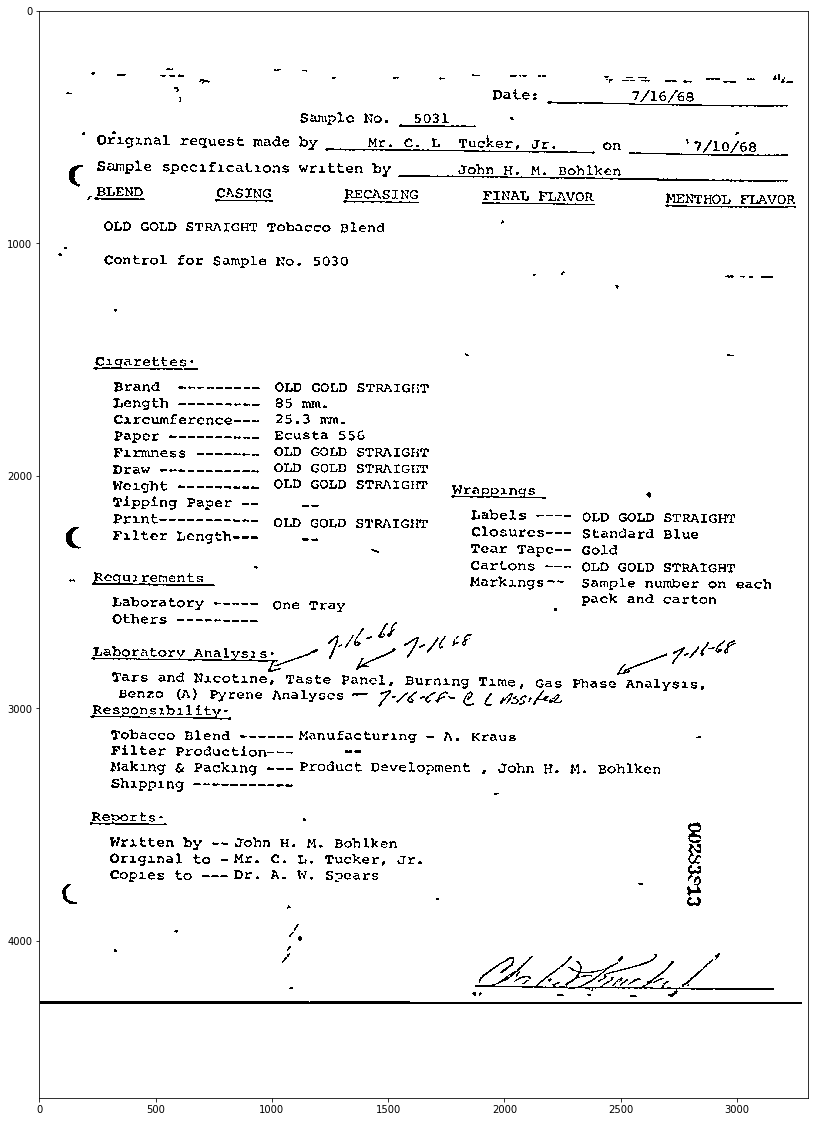

In [0]:
for r in result.distinct().collect():
    
    print("Original: %s" % r.path)
    img = r.image
    img_pil = to_pil_image(img, img.mode)

    plt.figure(figsize=(30,20))
    plt.imshow(img_pil, cmap='gray')
    
    
    print("Corrected: %s" % r.path)
    img = r.corrected_image
    img_pil = to_pil_image(img, img.mode)

    plt.figure(figsize=(30,20))
    plt.imshow(img_pil, cmap='gray')
    
    
    plt.show()

## Results with original image

In [0]:
grouped_results = result.groupBy("path", "pagenum").agg(F.concat_ws("", F.collect_list("text")).alias("text"))
for row in grouped_results.collect():
    print("Filename:\n%s , page: %d" % (row.path, row.pagenum))
    print("Recognized text:\n%s" % row.text)

Filename:
dbfs:/noised.pdf , page: 0
Recognized text:
 

Wels a Me a te ee a ' Date: . 1/36/68
Ce ES ota ~ Sample No. _ 5031 -. eae PTL ood :
“ Original request made by Mr. C. L. Tucker, Jr. ° on pa tot
Sample specifications written by _John H. M. Bohlken - 5
OI Be BON KER
, BLEND CASING RECASING ' FINAL FLAVOR MENTHOL FLAVOR
“OLD GOLD STRAIGHT Tobacco Blend : = a — " of
- Control. for Sample 1 No. 5030 at | 3 Ee a
*. Gigarettes: | ~
. Brana ------~-- OLD GOLD STRAIGHT
'. Length --------- 85 mm.
Circumference--~ 25.3 mn. o
Paper ~---------- Ecusta 556 ;
Firmness -----~- OLD GOLD STRAIGHT .
Draw -----~-+~-~-~-~~ OLD GOLD STRAIGHT | .,
Weight -------~- OLD GOLD STRAIGHT wrappings: .
Tipping Paper -- _ oa. , . .
abels ----
Print-----~----— OLD GOLD STRAIGHT slennneen Stongona STRAIGHT
C - Filter Length--- —-
~ _ Tear Tape-- Gold
. . Cartons --- OLD GOLD STRAIGHT
: =. Requirements: “ss 8 .. Markings-- Sample number on each
Ts . ‘pack and carton
Laboratory ----- One Tray oe

Others ---------

: | | LA
Laboratory Analysis o 7 jo eer
Tars and Nicotine, Taste Panel, Burning Time, Gas Phase Analysis,
. Benzo (A) Pyrene Analyses — 776 -€F- CL OSS 1 fede
Responsibility:

Tobacco Blend ------ Manufacturing ~ A. Kraus . vo

LE

Filter Production--- -- a
Making & Packing ~-- Product Development » John H. M. Bohlken -
Shipping ----------- _

Written by -- John H. M. Bohlken
Original to -Mr. C. L. Tucker, Jr.
Copies to ---Dr. A. W. Spears

>

## Results with corrected image

In [0]:
grouped_results = result.groupBy("path", "pagenum").agg(F.concat_ws("", F.collect_list("corrected_text")).alias("corrected_text"))
for row in grouped_results.collect():
    print("Filename:\n%s , page: %d" % (row.path, row.pagenum))
    print("Recognized text:\n%s" % row.corrected_text)

Filename:
dbfs:/noised.pdf , page: 0
Recognized text:
 

- > Date: 7/16/68
Sample No. _ 5031 >
° Oraginal request made by Mr. €. L Tucker, Jr. on ‘7/10/68
Sample specifications written by John H. M. Bohlken
, BLEND CASING RECASING FINAL FLAVOR MENTHOL FLAVOR

OLD GOLD STRAIGHT Tobacco Blend

° Control for Sample No. 5030

Cigarettes:

Brand -<--------= OLD GOLD STRAIGHT

Length --------- 85 mm.

Circumference~-~ 25.3 mn.

Paper eee eee ee Ecusta 556

Firymness -----—-. OLD GOLD STRAIGHT

Draw ---—---~-~~——. OLD GOLD STRAIGHT

Weaght mee eee OLD GOLD STRAIGHT Wra inds ‘

Tipping Paper -- --

Print----------- OLD GOLD STRAIGHT pees “777 OLD GOLD STRAIGHT
C Filter Length--- __ Closures--- Standard Blue

~ Tear Tape-- Gold
. Cartons --- OLD GOLD STRAIGHT

- Requirements _ Markings-~ Sample number on each

Laboratory ----- One Tray . pack and carton

Others ----~-----

Tars and Nicotine, Taste Panel, Burning Time, Gas Phase Analysis,
Benzo (A) Pyrene Analyses — 7-16 -CF~ C2 VOSS 1 Feb
Responsibility:

Tobacco Blend ------ Manufacturing - A. Kraus -
Filter Production--- --
Making & Packing --- Product Development , John H. M. Bohlken
Shipping ----------- .

Reports: .

Written by -- John H. M. Bohlken
Original to -Mr. C. L. Tucker, Jr.
Copies to --- Dr. A. W. Spears

a

/
e

In [0]:
result.columns

Out[64]: ['path',
 'modificationTime',
 'length',
 'image',
 'total_pages',
 'pagenum',
 'documentnum',
 'binarized_image',
 'opening_image',
 'corrected_image',
 'region',
 'image_with_regions',
 'confidence',
 'text',
 'positions',
 'confidence',
 'exception',
 'corrected_text',
 'corrected_positions']

## Abby output

In [0]:
abbyy = """-----
% Date: 7/16/68
X*: I; * • ■ Sample No. 5031___ — .*
•* Original request made by _____Mr. C. L. Tucker, Jr. on
Sample specifications written by
BLEND CASING RECASING
OLD GOLD STRAIGHT Tobacco Blend
Control for Sample No. 5030
John H. M. Bohlken
FINAL FLAVOR
) 7/10/68
MENTHOL FLAVOR
• Cigarettes; * . .v\ . /,*, *, S •
Brand --------- OLD GOLD STRAIGHT -V . ••••
; . L e n g t h ------- — 85 mm. . : '
Circumference-- 25.3 mm. • ' *;. • •
P a p e r ---------- Ecusta 556 • * .
F i r m n e s s---- —— OLD GOLD STRAIGHT . ! •■'
D r a w ___________ OLD GOLD STRAIGHT
W e i g h t --------- 0LD GOLD STRAIGHT Wrappings: « -
Tipping Paper — — *
p H n f —. — — _ _ ~ L a b e l s ----OLD GOLD STRAIGHT
( • Filter Length-- . — Closures--- Standard Blue .
^ ^ ; • Tear Tape— Gold
Cartons --- OLD GOLD STRAIGHT
s Requirements: . - •' • Markings-- Sample number on each
• pack and carton Laboratory----- One Tray .
O t h e r s --------- * , s • • . 4
Laboratory A n a l ysis^ I " '/***• * 7 ' ^ ^
Tars and Nicotine, Taste Panel, Burning Time, Gas Phase Analysis,
Benzo (A) Pyrene Analyses — J-ZZ-Zf'- (£. / •
Responsibility;
Tobacco B l e n d ------Manufacturing - A. Kraus . . * -
Filter Production--- —
• Making & P a c k i n g---Product Development , John H. M. Bohlken
Shipping -----------
Reports:
t
Written by — John H. M. Bohlken
Original to - Mr. C. L. Tucker, Jr.
Copies t o ---Dr. A. W. Spears
• 9 ..
"""

Original: dbfs:/noised.pdf
Corrected: dbfs:/noised.pdf

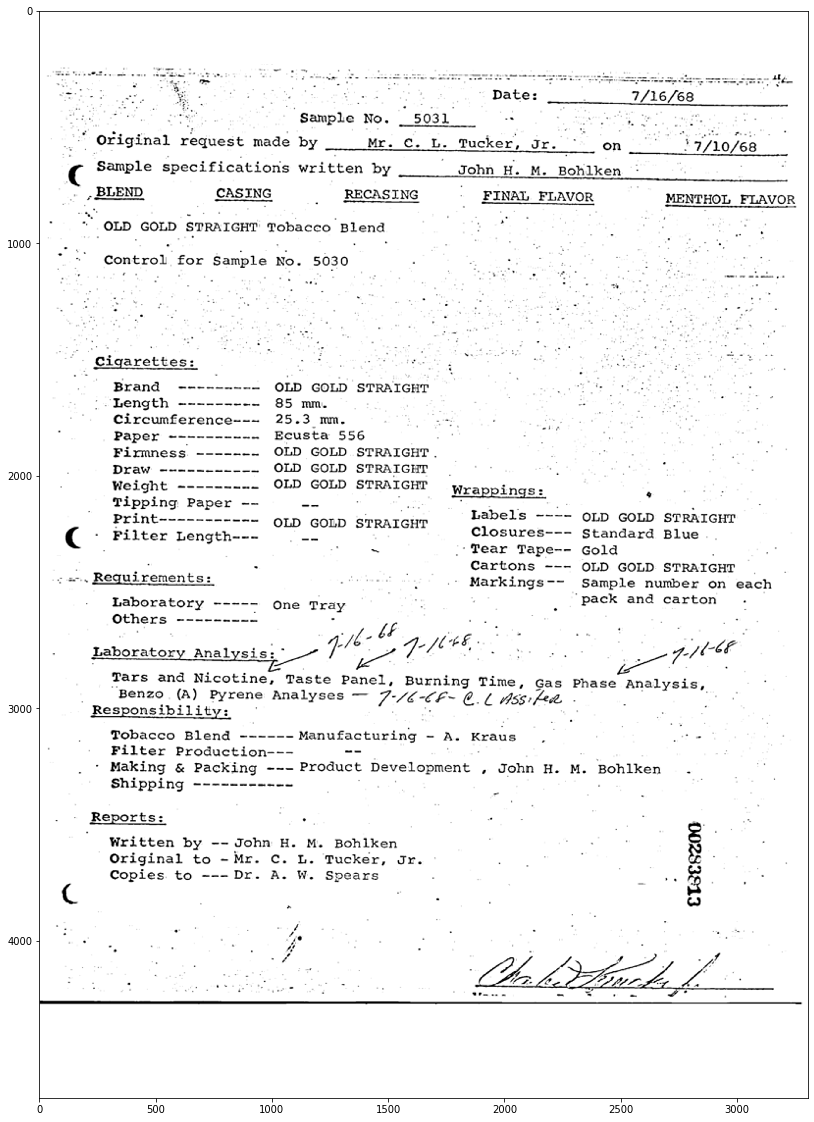

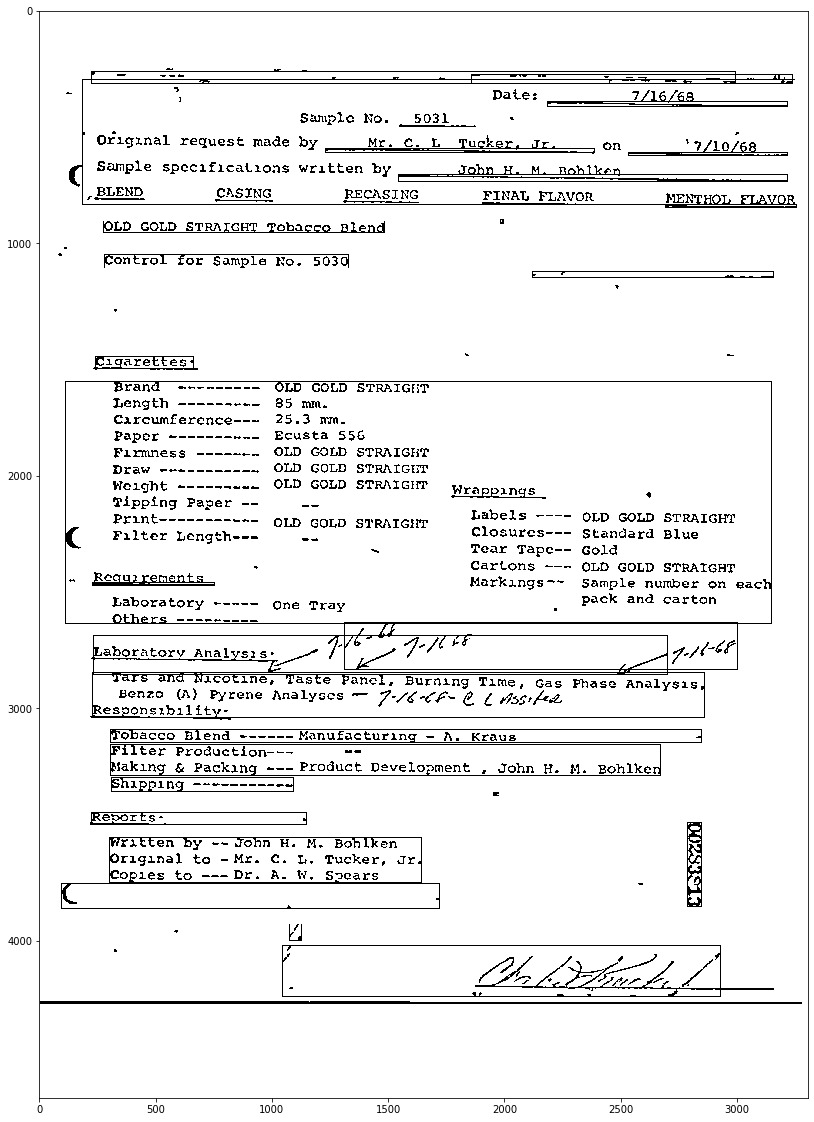

In [0]:
for r in result.select("path","image","image_with_regions").distinct().collect():
    
    print("Original: %s" % r.path)
    img = r.image
    img_pil = to_pil_image(img, img.mode)

    plt.figure(figsize=(30,20))
    plt.imshow(img_pil, cmap='gray')
    
    
    print("Corrected: %s" % r.path)
    img = r.image_with_regions
    img_pil = to_pil_image(img, img.mode)

    plt.figure(figsize=(30,20))
    plt.imshow(img_pil, cmap='gray')
    
    
    plt.show()

# Image (or Natural Scene) to Text

In [0]:
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/images/text_with_noise.png
dbutils.fs.cp("file:/databricks/driver/text_with_noise.png", "dbfs:/")

Out[68]: True

In [0]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/ocr/natural_scene.jpeg
dbutils.fs.cp("file:/databricks/driver/natural_scene.jpeg", "dbfs:/")

Out[72]: True

## Text from Scene

## Read DOCX document as binary file

# DOCX Processing (version 1.10.0)

Original: dbfs:/text_with_noise.png
Binarized
Removing objects

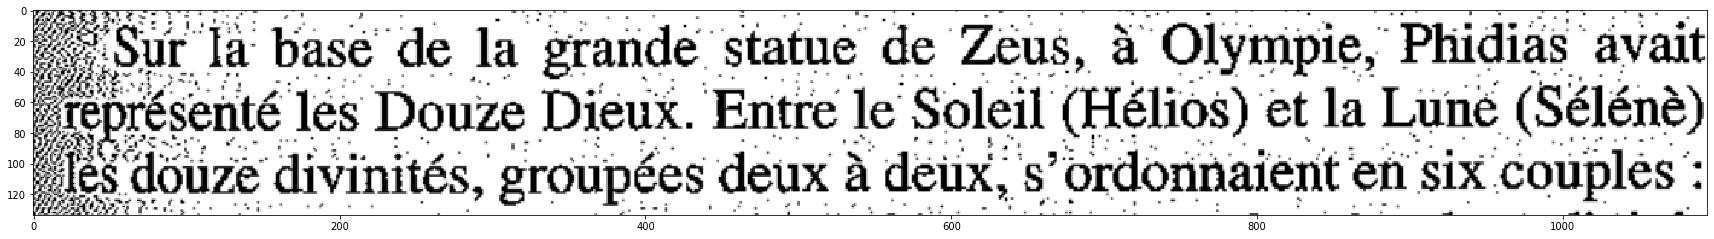

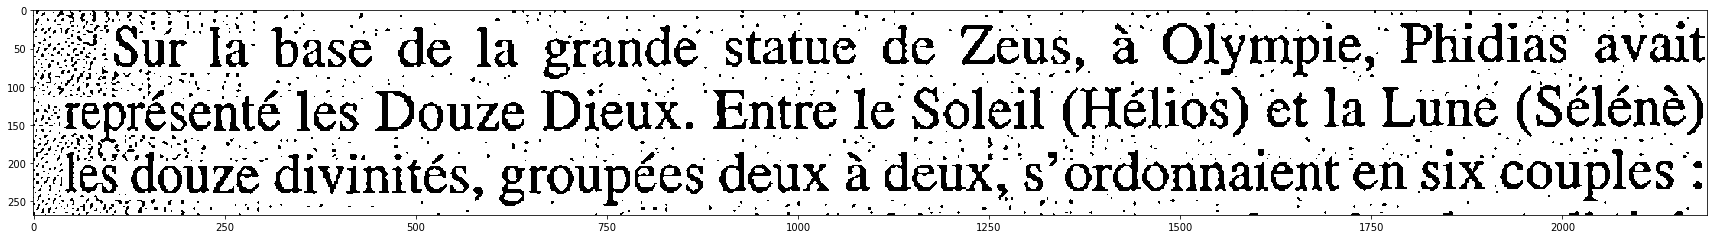

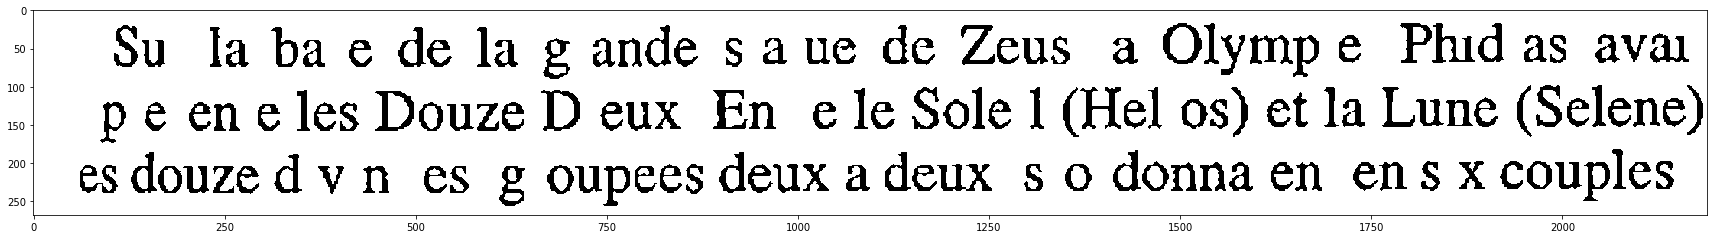

In [0]:
image_df = spark.read.format("binaryFile").load('/text_with_noise.png').cache()

# Read binary as image
binary_to_image = BinaryToImage()
binary_to_image.setInputCol("content")
binary_to_image.setOutputCol("image")

# Scale image
scaler = ImageScaler()
scaler.setInputCol("image")
scaler.setOutputCol("scaled_image")
scaler.setScaleFactor(2.0)

# Binarize using adaptive tresholding
binarizer = ImageAdaptiveThresholding()
binarizer.setInputCol("scaled_image")
binarizer.setOutputCol("binarized_image")
binarizer.setBlockSize(71)
binarizer.setOffset(65)

remove_objects = ImageRemoveObjects()
remove_objects.setInputCol("binarized_image")
remove_objects.setOutputCol("cleared_image")
remove_objects.setMinSizeObject(400)
remove_objects.setMaxSizeObject(4000)

# Run OCR
ocr = ImageToText()
ocr.setInputCol("cleared_image")
ocr.setOutputCol("text")
ocr.setConfidenceThreshold(50)
ocr.setIgnoreResolution(False)

# OCR pipeline
noisy_pipeline = PipelineModel(stages=[
    binary_to_image,
    scaler,
    binarizer,
    remove_objects,
    ocr
])


result = noisy_pipeline \
.transform(image_df) \
.cache()


for r in result.distinct().collect():
  
    print("Original: %s" % r.path)
    img = r.image
    img_pil = to_pil_image(img, img.mode)

    plt.figure(figsize=(30,20))
    plt.imshow(img_pil, cmap='gray')
    
    print("Binarized")
    img = r.binarized_image
    img_pil = to_pil_image(img, img.mode)

    plt.figure(figsize=(30,20))
    plt.imshow(img_pil, cmap='gray')
  
    print("Removing objects")
    img = r.cleared_image
    img_pil = to_pil_image(img, img.mode)

    plt.figure(figsize=(30,20))
    plt.imshow(img_pil, cmap='gray')
    
    
    plt.show()

In [0]:
print("\n".join([row.text for row in result.select("text").collect()]))

Su la ba e de la g ande saue de Zeus a Olympe Phid as avai
pe eneles Douze D eux En ele Sole | (Hel os) et la Lune (Selene)
esdouze dv n es g oupees deux adeux s o donna en ens x couples

In [0]:
doc_example_df = spark.read.format("binaryFile").load("file:/databricks/python/lib/python3.7/site-packages/sparkocr/resources/ocr/docs/doc2.docx").cache()

In [0]:
doc_example_df.show()

+--------------------+-------------------+------+--------------------+
 path| modificationTime|length| content|
+--------------------+-------------------+------+--------------------+
file:/databricks/...|2021-05-03 19:41:29| 33260|[50 4B 03 04 14 0...|
+--------------------+-------------------+------+--------------------+

In [0]:
import pkg_resources
pkg_resources.resource_filename('sparkocr', 'resources/ocr/docs/doc2.docx')

Out[79]: '/databricks/python/lib/python3.7/site-packages/sparkocr/resources/ocr/docs/doc2.docx'

## DocxtoText

Original: dbfs:/natural_scene.jpeg
Binarized
Removing objects
Morphology closing

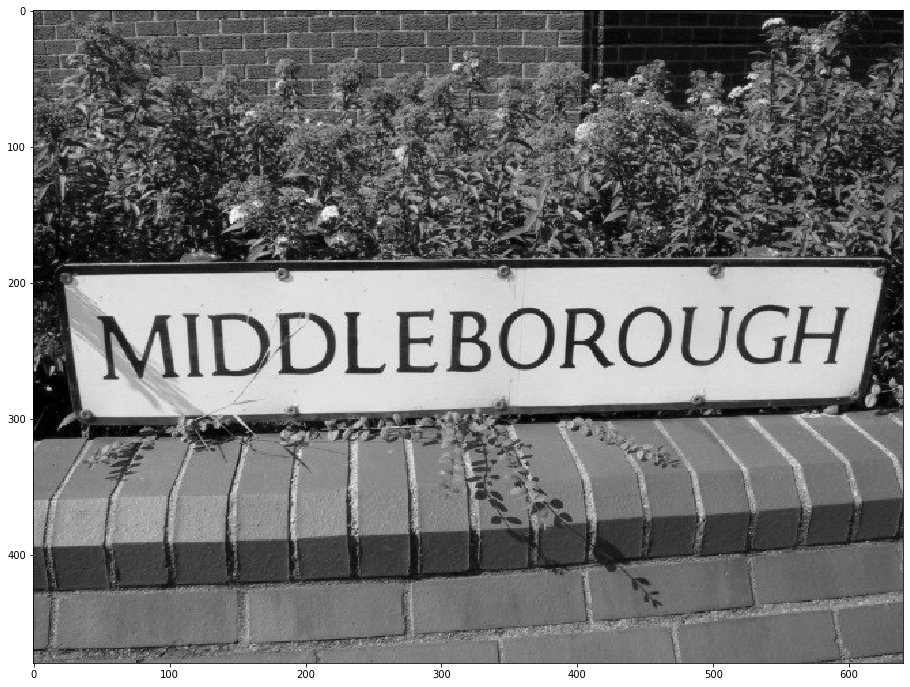

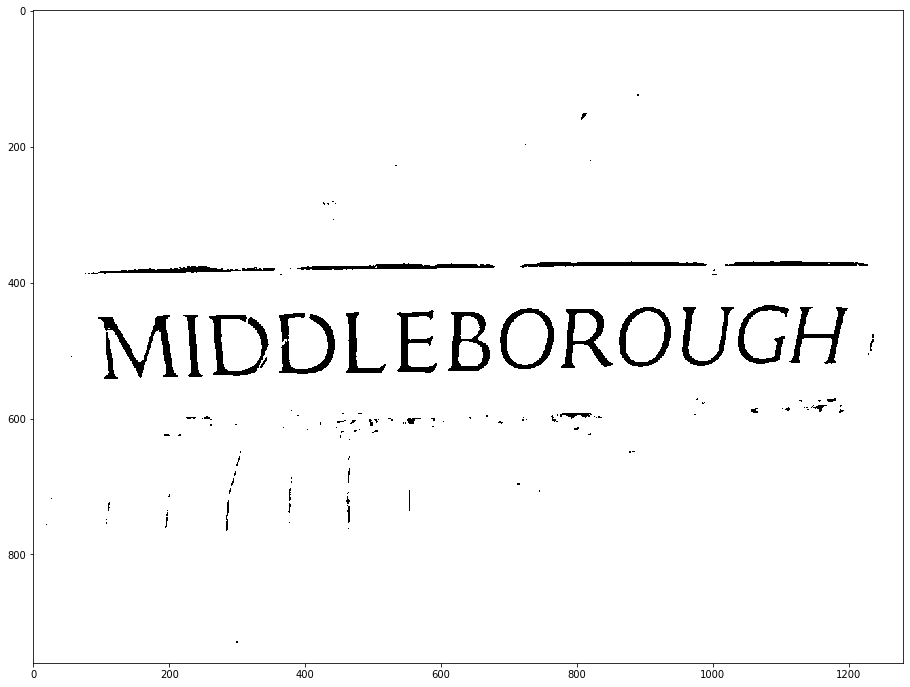

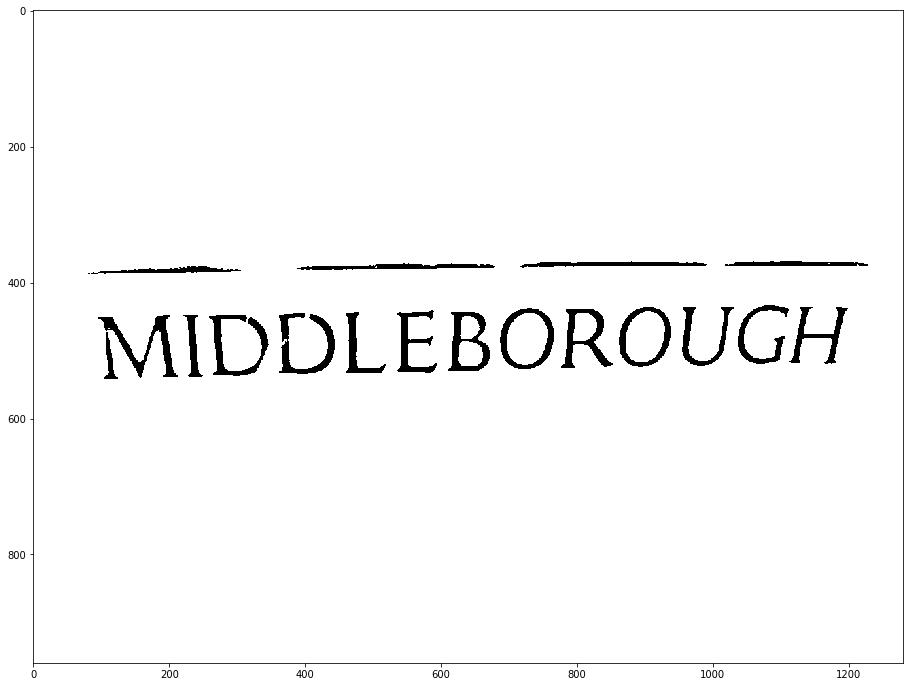

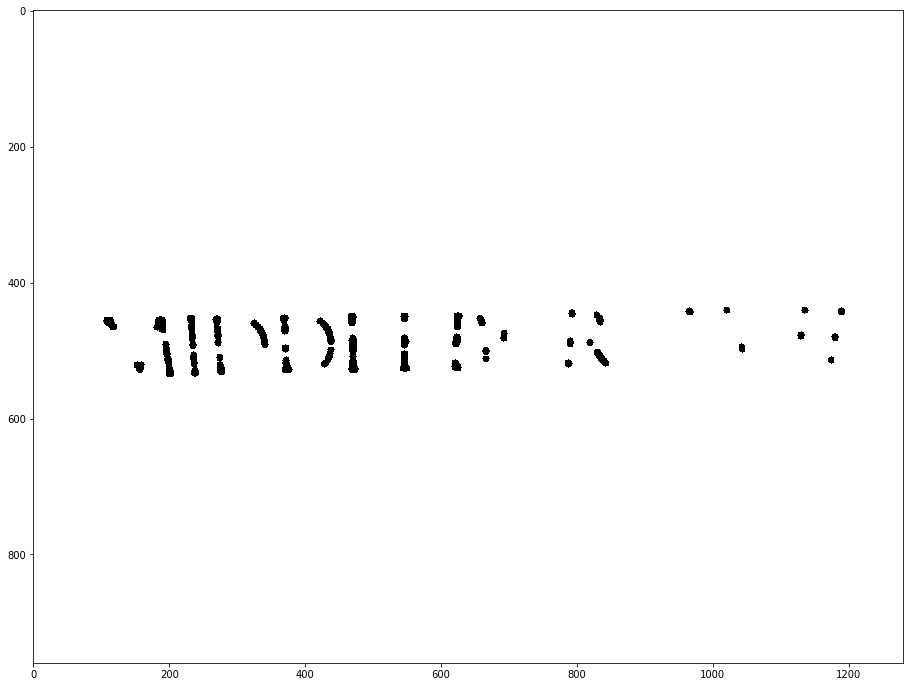

In [0]:
image_df = spark.read.format("binaryFile").load('/natural_scene.jpeg').cache()

# Apply morphology opening
morpholy_operation = ImageMorphologyOperation()
morpholy_operation.setKernelShape(KernelShape.DISK)
morpholy_operation.setKernelSize(5)
morpholy_operation.setOperation("closing")
morpholy_operation.setInputCol("cleared_image")
morpholy_operation.setOutputCol("corrected_image")

# Run OCR
ocr = ImageToText()
ocr.setInputCol("corrected_image")
ocr.setOutputCol("text")
ocr.setConfidenceThreshold(50)
ocr.setIgnoreResolution(False)

# OCR pipeline
scene_pipeline = PipelineModel(stages=[
    binary_to_image,
    scaler,
    binarizer,
    remove_objects,
    morpholy_operation,
    ocr
])

result = scene_pipeline \
.transform(image_df) \
.cache()


for r in result.distinct().collect():
      
    print("Original: %s" % r.path)
    img = r.image
    img_pil = to_pil_image(img, img.mode)

    plt.figure(figsize=(20,12))
    plt.imshow(img_pil, cmap='gray')
    
    print("Binarized")
    img = r.binarized_image
    img_pil = to_pil_image(img, img.mode)

    plt.figure(figsize=(20,12))
    plt.imshow(img_pil, cmap='gray')
  
    print("Removing objects")
    img = r.cleared_image
    img_pil = to_pil_image(img, img.mode)

    plt.figure(figsize=(20,12))
    plt.imshow(img_pil, cmap='gray')
    
    print("Morphology closing")
    img = r.corrected_image
    img_pil = to_pil_image(img, img.mode)

    plt.figure(figsize=(20,12))
    plt.imshow(img_pil, cmap='gray')
    
    
    plt.show()

### Extract text using DocToText transformer

In [0]:
from sparkocr.transformers import *

doc_to_text = DocToText()
doc_to_text.setInputCol("content")
doc_to_text.setOutputCol("text")

result = doc_to_text.transform(doc_example_df)

### Display result DataFrame

In [0]:
result.show()

+--------------------+-------------------+------+--------------------+---------+-------+
 path| modificationTime|length| text|exception|pagenum|
+--------------------+-------------------+------+--------------------+---------+-------+
file:/databricks/...|2021-05-03 19:41:29| 33260|Sample Document
T...| null| 0|
+--------------------+-------------------+------+--------------------+---------+-------+

### Display extracted text

In [0]:
print("\n".join([row.text for row in result.select("text").collect()]))

Sample Document
This document was created using accessibility techniques for headings, lists, image alternate text, tables, and columns. It should be completely accessible using assistive technologies such as screen readers.
Headings
There are eight section headings in this document. At the beginning, "Sample Document" is a level 1 heading. The main section headings, such as "Headings" and "Lists" are level 2 headings. The Tables section contains two sub-headings, "Simple Table" and "Complex Table," which are both level 3 headings.
Lists
The following outline of the sections of this document is an ordered (numbered) list with six items. The fifth item, "Tables," contains a nested unordered (bulleted) list with two items.
Headings 
Lists 
Links 
Images 
Tables 
Simple Tables 
Complex Tables 
Columns 
Links
In web documents, links can point different locations on the page, different pages, or even downloadable documents, such as Word documents or PDFs:
Top of this Page
Sample Document
Sample Document (docx)
Images
Documents may contain images. For example, there is an image of the web accessibility symbol to the left of this paragraph. Its alternate text is "Web Access Symbol".
Alt text should communicate what an image means, not how it looks.






Some images, such as charts or graphs, require long descriptions, but not all document types allow that. In web pages, long descriptions may be provided in several ways: on the page below the image, via a link below the image, or via a link on the image.




Tables
Simple Tables
Simple tables have a uniform number of columns and rows, without any merged cells:
Screen Reader	Responses	Share
JAWS	853	49%
NVDA	238	14%
Window-Eyes	214	12%
System Access	181	10%
VoiceOver	159	9%


Complex Tables
The following is a complex table, using merged cells as headers for sections within the table. This can't be made accessible in all types of documents:
	May 2012 September 2010
Screen Reader	Responses	Share	Responses	Share 
JAWS	853	49%	727	59% 
NVDA	238	14%	105	9% 
Window-Eyes	214	12%	138	11% 
System Access	181	10%	58	5% 
VoiceOver	159	9%	120	10%

 



Columns

This is an example of columns. With columns, the page is split into two or more horizontal sections. Unlike tables, in which you usually read across a row and then down to the next, in columns, you read down a column and then across to the next.
When columns are not created correctly, screen readers may run lines together, reading the first line of the first column, then the first line of the second column, then the second line of the first column, and so on. Obviously, that is not accessible.

## DocxToTextTable
### (Extracting table data from Microsoft DOCX documents)

### Preview document using DocToPdf and PdfToImage transformers

In [0]:
for r in image_df.select("image").collect():
    display_image(r.image)

Original: file:/databricks/python/lib/python3.7/site-packages/sparkocr/resources/ocr/docs/doc2.docx
Original: file:/databricks/python/lib/python3.7/site-packages/sparkocr/resources/ocr/docs/doc2.docx
Original: file:/databricks/python/lib/python3.7/site-packages/sparkocr/resources/ocr/docs/doc2.docx

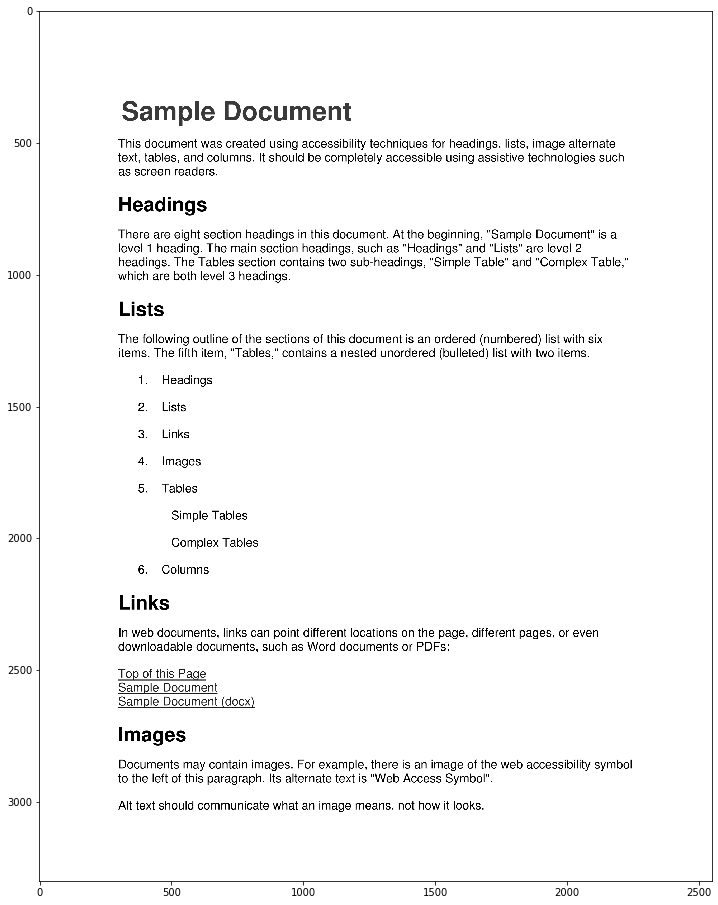

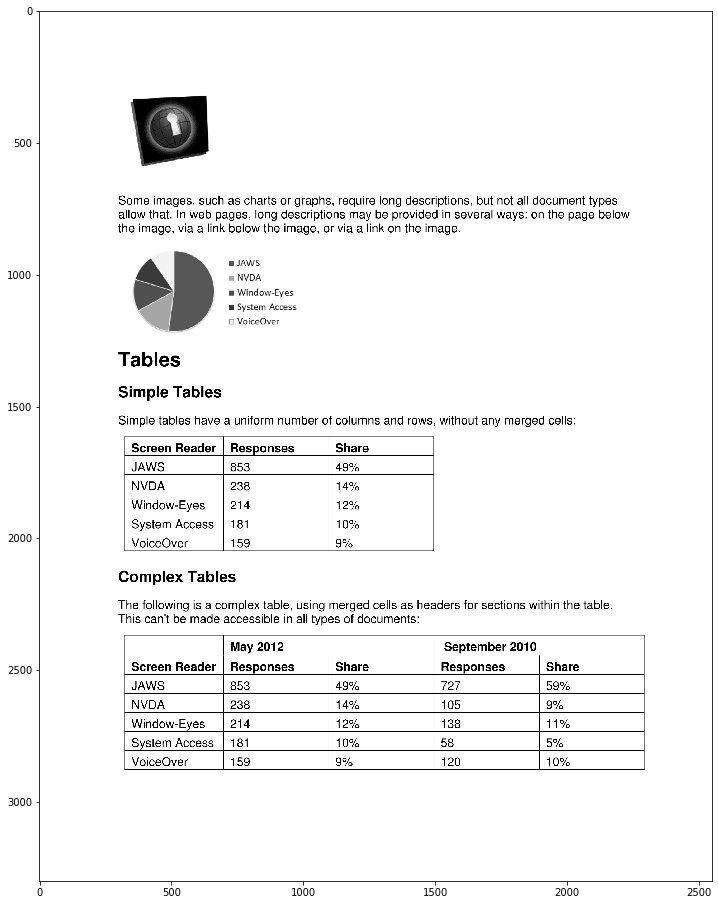

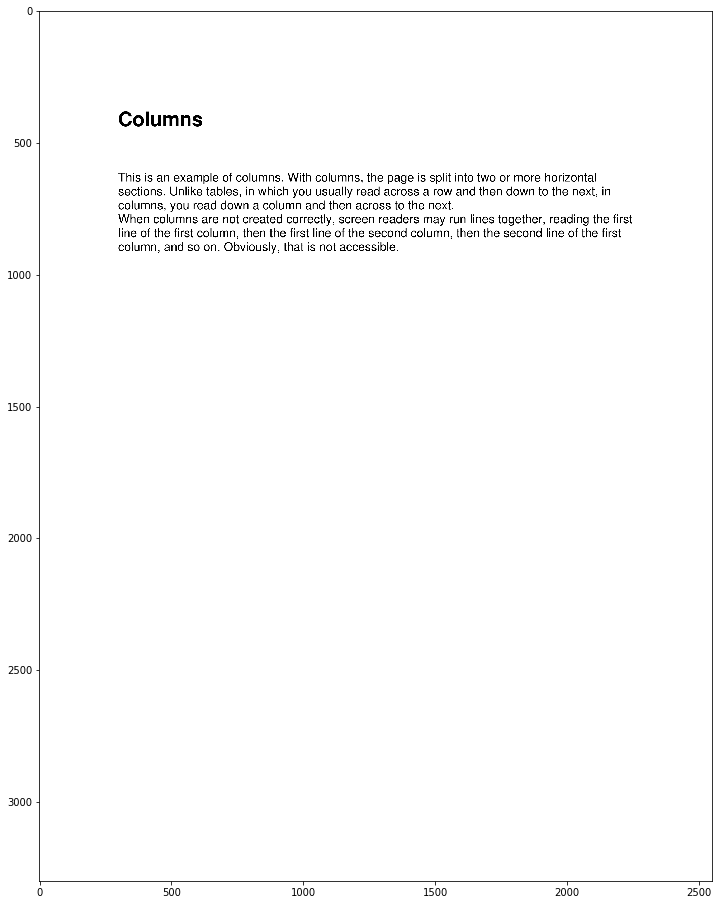

In [0]:
image_df = PdfToImage().transform(DocToPdf().setOutputCol("content").transform(doc_example_df))

for r in image_df.distinct().collect():
      
    print("Original: %s" % r.path)
    img = r.image
    img_pil = to_pil_image(img, img.mode)

    plt.figure(figsize=(24,16))
    plt.imshow(img_pil, cmap='gray')

### Extract text using DocToText transformer

In [0]:
doc_to_table = DocToTextTable()
doc_to_table.setInputCol("content")
doc_to_table.setOutputCol("tables")

result = doc_to_table.transform(doc_example_df)

result.show()

+--------------------+-------------------+------+--------------------+---------+
 path| modificationTime|length| tables|exception|
+--------------------+-------------------+------+--------------------+---------+
file:/databricks/...|2021-05-03 19:41:29| 33260|[[0, 0, 0.0, 0.0,...| null|
file:/databricks/...|2021-05-03 19:41:29| 33260|[[1, 0, 0.0, 0.0,...| null|
+--------------------+-------------------+------+--------------------+---------+

In [0]:
result.select(result["tables.chunks"].getItem(3)["chunkText"]).show(truncate=False)

+------------------------------------------+
tables.chunks AS chunks#14283[3].chunkText|
+------------------------------------------+
[Window-Eyes, 214, 12%] |
[NVDA, 238, 14%, 105, 9% ] |
+------------------------------------------+

### Display extracted data in JSON format

In [0]:
import json
df_json = result.select("tables").toJSON()
for row in df_json.collect():
    print(json.dumps(json.loads(row), indent=4))

{
 "tables": {
 "area": {
 "index": 0,
 "page": 0,
 "x": 0.0,
 "y": 0.0,
 "width": 0.0,
 "height": 0.0
 },
 "chunks": [
 [
 {
 "chunkText": "Screen Reader",
 "x": 0.0,
 "y": 0.0,
 "width": 90.0,
 "height": 0.0
 },
 {
 "chunkText": "Responses",
 "x": 0.0,
 "y": 0.0,
 "width": 95.75,
 "height": 0.0
 },
 {
 "chunkText": "Share",
 "x": 0.0,
 "y": 0.0,
 "width": 95.75,
 "height": 0.0
 }
 ],
 [
 {
 "chunkText": "JAWS",
 "x": 0.0,
 "y": 0.0,
 "width": 90.0,
 "height": 0.0
 },
 {
 "chunkText": "853",
 "x": 0.0,
 "y": 0.0,
 "width": 95.75,
 "height": 0.0
 },
 {
 "chunkText": "49%",
 "x": 0.0,
 "y": 0.0,
 "width": 95.75,
 "height": 0.0
 }
 ],
 [
 {
 "chunkText": "NVDA",
 "x": 0.0,
 "y": 0.0,
 "width": 90.0,
 "height": 0.0
 },
 {
 "chunkText": "238",
 "x": 0.0,
 "y": 0.0,
 "width": 95.75,
 "height": 0.0
 },
 {
 "chunkText": "14%",
 "x": 0.0,
 "y": 0.0,
 "width": 95.75,
 "height": 0.0
 }
 ],
 [
 {
 "chunkText": "Window-Eyes",
 "x": 0.0,
 "y": 0.0,
 "width": 90.0,
 "height": 0.0
 },
 {
 "chunkText": "214",
 "x": 0.0,
 "y": 0.0,
 "width": 95.75,
 "height": 0.0
 },
 {
 "chunkText": "12%",
 "x": 0.0,
 "y": 0.0,
 "width": 95.75,
 "height": 0.0
 }
 ],
 [
 {
 "chunkText": "System Access",
 "x": 0.0,
 "y": 0.0,
 "width": 90.0,
 "height": 0.0
 },
 {
 "chunkText": "181",
 "x": 0.0,
 "y": 0.0,
 "width": 95.75,
 "height": 0.0
 },
 {
 "chunkText": "10%",
 "x": 0.0,
 "y": 0.0,
 "width": 95.75,
 "height": 0.0
 }
 ],
 [
 {
 "chunkText": "VoiceOver",
 "x": 0.0,
 "y": 0.0,
 "width": 90.0,
 "height": 0.0
 },
 {
 "chunkText": "159",
 "x": 0.0,
 "y": 0.0,
 "width": 95.75,
 "height": 0.0
 },
 {
 "chunkText": "9%",
 "x": 0.0,
 "y": 0.0,
 "width": 95.75,
 "height": 0.0
 }
 ]
 ]
 }
}
{
 "tables": {
 "area": {
 "index": 1,
 "page": 0,
 "x": 0.0,
 "y": 0.0,
 "width": 0.0,
 "height": 0.0
 },
 "chunks": [
 [
 {
 "chunkText": "",
 "x": 0.0,
 "y": 0.0,
 "width": 90.0,
 "height": 0.0
 },
 {
 "chunkText": "May 2012",
 "x": 0.0,
 "y": 0.0,
 "width": 191.5,
 "height": 0.0
 },
 {
 "chunkText": " September 2010",
 "x": 0.0,
 "y": 0.0,
 "width": 191.55,
 "height": 0.0
 }
 ],
 [
 {
 "chunkText": "Screen Reader",
 "x": 0.0,
 "y": 0.0,
 "width": 90.0,
 "height": 0.0
 },
 {
 "chunkText": "Responses",
 "x": 0.0,
 "y": 0.0,
 "width": 95.75,
 "height": 0.0
 },
 {
 "chunkText": "Share",
 "x": 0.0,
 "y": 0.0,
 "width": 95.75,
 "height": 0.0
 },
 {
 "chunkText": "Responses",
 "x": 0.0,
 "y": 0.0,
 "width": 95.75,
 "height": 0.0
 },
 {
 "chunkText": "Share ",
 "x": 0.0,
 "y": 0.0,
 "width": 95.8,
 "height": 0.0
 }
 ],
 [
 {
 "chunkText": "JAWS",
 "x": 0.0,
 "y": 0.0,
 "width": 90.0,
 "height": 0.0
 },
 {
 "chunkText": "853",
 "x": 0.0,
 "y": 0.0,
 "width": 95.75,
 "height": 0.0
 },
 {
 "chunkText": "49%",
 "x": 0.0,
 "y": 0.0,
 "width": 95.75,
 "height": 0.0
 },
 {
 "chunkText": "727",
 "x": 0.0,
 "y": 0.0,
 "width": 95.75,
 "height": 0.0
 },
 {
 "chunkText": "59% ",
 "x": 0.0,
 "y": 0.0,
 "width": 95.8,
 "height": 0.0
 }
 ],
 [
 {
 "chunkText": "NVDA",
 "x": 0.0,
 "y": 0.0,
 "width": 90.0,
 "height": 0.0
 },
 {
 "chunkText": "238",
 "x": 0.0,
 "y": 0.0,
 "width": 95.75,
 "height": 0.0
 },
 {
 "chunkText": "14%",
 "x": 0.0,
 "y": 0.0,
 "width": 95.75,
 "height": 0.0
 },
 {
 "chunkText": "105",
 "x": 0.0,
 "y": 0.0,
 "width": 95.75,
 "height": 0.0
 },
 {
 "chunkText": "9% ",
 "x": 0.0,
 "y": 0.0,
 "width": 95.8,
 "height": 0.0
 }
 ],
 [
 {
 "chunkText": "Window-Eyes",
 "x": 0.0,
 "y": 0.0,
 "width": 90.0,
 "height": 0.0
 },
 {
 "chunkText": "214",
 "x": 0.0,
 "y": 0.0,
 "width": 95.75,
 "height": 0.0
 },
 {
 "chunkText": "12%",
 "x": 0.0,
 "y": 0.0,
 "width": 95.75,
 "height": 0.0
 },
 {
 "chunkText": "138",
 "x": 0.0,
 "y": 0.0,
 "width": 95.75,
 "height": 0.0
 },
 {
 "chunkText": "11% ",
 "x": 0.0,
 "y": 0.0,
 "width": 95.8,
 "height": 0.0
 }
 ],
 [
 {
 "chunkText": "System Access",
 "x": 0.0,
 "y": 0.0,
 "width": 90.0,
 "height": 0.0
 },
 {
 "chunkText": "181",
 "x": 0.0,
 "y": 0.0,
 "width": 95.75,
 "height": 0.0
 },
 {
 "chunkText": "10%",
 "x": 0.0,
 "y": 0.0,
 "width": 95.75,
 "he

# Text to Pdf

In [0]:
def pipeline():
    # Transforrm PDF document to images per page
    pdf_to_image = PdfToImage() \
        .setInputCol("content") \
        .setOutputCol("image") \
        .setKeepInput(True)
    
    # Run OCR
    ocr = ImageToText() \
        .setInputCol("image") \
        .setOutputCol("text") \
        .setConfidenceThreshold(60) \
        .setIgnoreResolution(False) \
        .setPageSegMode(PageSegmentationMode.SPARSE_TEXT)
    
    # Render results to PDF
    textToPdf = TextToPdf() \
        .setInputCol("positions") \
        .setInputImage("image") \
        .setOutputCol("pdf")

    pipeline = PipelineModel(stages=[
        pdf_to_image,
        ocr,
        textToPdf
    ])
    
    return pipeline

In [0]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/ocr/test_document.pdf
dbutils.fs.cp("file:/databricks/driver/test_document.pdf", "dbfs:/")

Out[94]: True

In [0]:
pdf_example_df = spark.read.format("binaryFile").load('/test_document.pdf').cache()


In [0]:
result = pipeline().transform(pdf_example_df).cache()

In [0]:
result.columns

Out[97]: ['path', 'text', 'pdf', 'exception']

Out[99]:

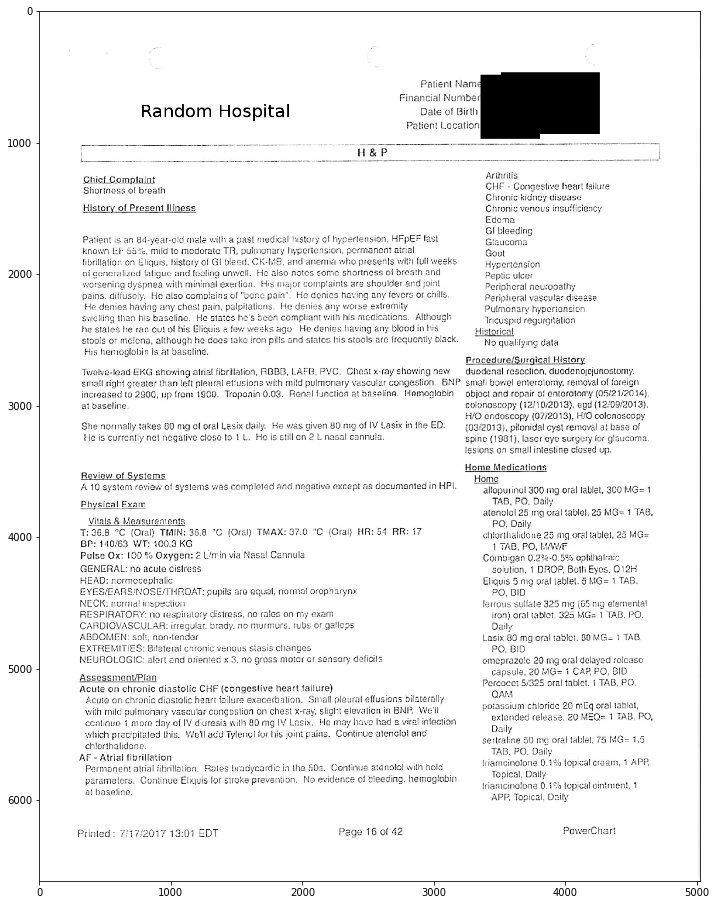

<matplotlib.image.AxesImage at 0x7f8cd4c1c290>

In [0]:
image_df = PdfToImage().transform(pdf_example_df).select("image").collect()[0].image

img_pil = to_pil_image(image_df, image_df.mode)

plt.figure(figsize=(24,16))
plt.imshow(img_pil, cmap='gray')

In [0]:
# Store results to pdf file
pdf = result.select("pdf").head().pdf

pdfFile = open("result.pdf", "wb")

pdfFile.write(pdf)

pdfFile.close()

Original: dbfs:/test_document.pdf
Original: dbfs:/test_document.pdf

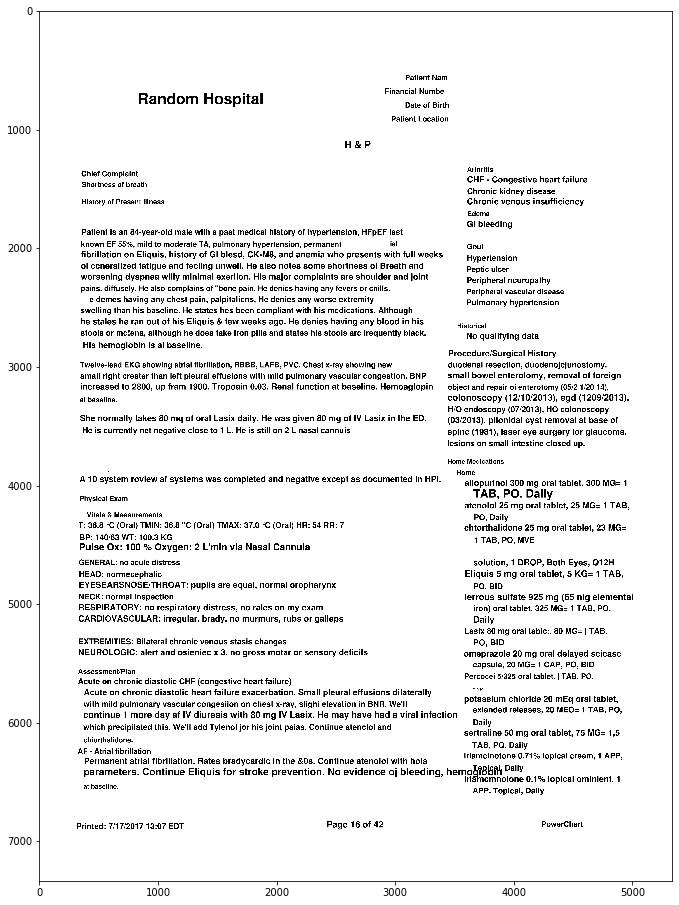

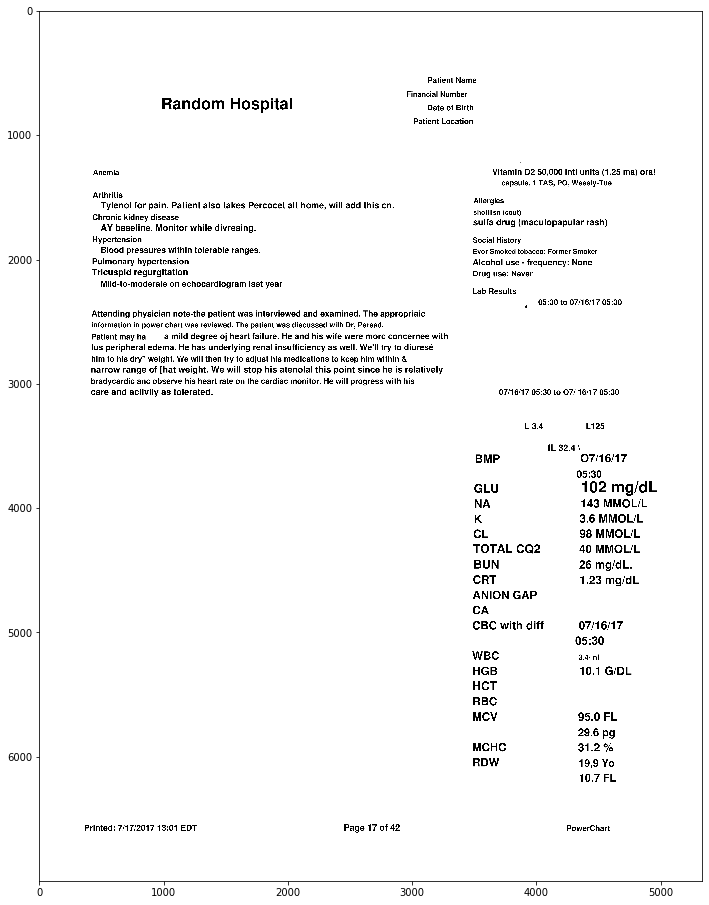

In [0]:
# Convert pdf to image and display¶

image_df = PdfToImage() \
    .setInputCol("pdf") \
    .setOutputCol("image") \
    .transform(result.select("pdf", "path"))

    
for r in image_df.distinct().collect():
      
    print("Original: %s" % r.path)
    img = r.image
    img_pil = to_pil_image(img, img.mode)

    plt.figure(figsize=(24,16))
    plt.imshow(img_pil, cmap='gray')


# DICOM Image Deidentifier

## Deidentification Pipeline

In [0]:
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession

from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
import sparknlp_jsl

In [0]:
def deidentification_nlp_pipeline(input_column, prefix = ""):
    document_assembler = DocumentAssembler() \
        .setInputCol(input_column) \
        .setOutputCol(prefix + "document")

    # Sentence Detector annotator, processes various sentences per line
    sentence_detector = SentenceDetector() \
        .setInputCols([prefix + "document"]) \
        .setOutputCol(prefix + "sentence")

    tokenizer = Tokenizer() \
        .setInputCols([prefix + "sentence"]) \
        .setOutputCol(prefix + "token")

    # Clinical word embeddings
    word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token"]) \
        .setOutputCol(prefix + "embeddings")
    # NER model trained on i2b2 (sampled from MIMIC) dataset
    clinical_ner = MedicalNerModel.pretrained("ner_deid_large", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "embeddings"]) \
        .setOutputCol(prefix + "ner")

    custom_ner_converter = NerConverter() \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "ner"]) \
        .setOutputCol(prefix + "ner_chunk") \
        .setWhiteList(['NAME', 'AGE', 'CONTACT', 'LOCATION', 'PROFESSION', 'PERSON', 'DATE'])

    nlp_pipeline = Pipeline(stages=[
            document_assembler,
            sentence_detector,
            tokenizer,
            word_embeddings,
            clinical_ner,
            custom_ner_converter
        ])
    empty_data = spark.createDataFrame([[""]]).toDF(input_column)
    nlp_model = nlp_pipeline.fit(empty_data)
    return nlp_model

## Define OCR transformers and pipeline

In [0]:
# Convert to images
binary_to_image = BinaryToImage() \
    .setInputCol("content") \
    .setOutputCol("image_raw")

# Extract text from image
ocr = ImageToText() \
    .setInputCol("image_raw") \
    .setOutputCol("text") \
    .setIgnoreResolution(False) \
    .setPageIteratorLevel(PageIteratorLevel.SYMBOL) \
    .setPageSegMode(PageSegmentationMode.SPARSE_TEXT) \
    .setConfidenceThreshold(70)

# Found coordinates of sensitive data
position_finder = PositionFinder() \
    .setInputCols("ner_chunk") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions") \
    .setMatchingWindow(1000) \
    .setPadding(1)

# Draw filled rectangle for hide sensitive data
drawRegions = ImageDrawRegions()  \
    .setInputCol("image_raw")  \
    .setInputRegionsCol("coordinates")  \
    .setOutputCol("image_with_regions")  \
    .setFilledRect(True) \
    .setRectColor(Color.gray)
    

# OCR pipeline
pipeline = Pipeline(stages=[
    binary_to_image,
    ocr,
    deidentification_nlp_pipeline(input_column="text"),
    position_finder,
    drawRegions
])

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][OK!]
ner_deid_large download started this may take some time.
Approximate size to download 14.1 MB
[ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][OK!]

## Load Image

In [0]:
import pkg_resources
pkg_resources.resource_filename('sparkocr', 'resources/ocr/images/p1.jpg')

Out[105]: '/databricks/python/lib/python3.7/site-packages/sparkocr/resources/ocr/images/p1.jpg'

In [0]:
image_df = spark.read.format("binaryFile").load("file:/databricks/python/lib/python3.7/site-packages/sparkocr/resources/ocr/images/p1.jpg")

## Run Pipeline

In [0]:
result = pipeline.fit(image_df).transform(image_df).cache()

In [0]:
result.select('text').show(1, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
text |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [0]:
# Chunks to hide
result.select('ner_chunk').show(2, False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+
ner_chunk |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+
[[chunk, 193, 202, 04/04/2018, [entity -> DATE, sentence -> 1, chunk -> 0], []], [chunk, 3388, 3397, 04/12/2018, [entity -> DATE, sentence -> 20, chunk -> 1], []]]|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+

In [0]:
# Coordinates of Chunks to Hide
result.select('coordinates').show(2, False)

+------------------------------------------------------------------------+
coordinates |
+------------------------------------------------------------------------+
[[0, 0, 356.0, 1053.0, 217.0, 41.0], [1, 0, 495.0, 3527.0, 231.0, 43.0]]|
+------------------------------------------------------------------------+

## Show original and deidentified images

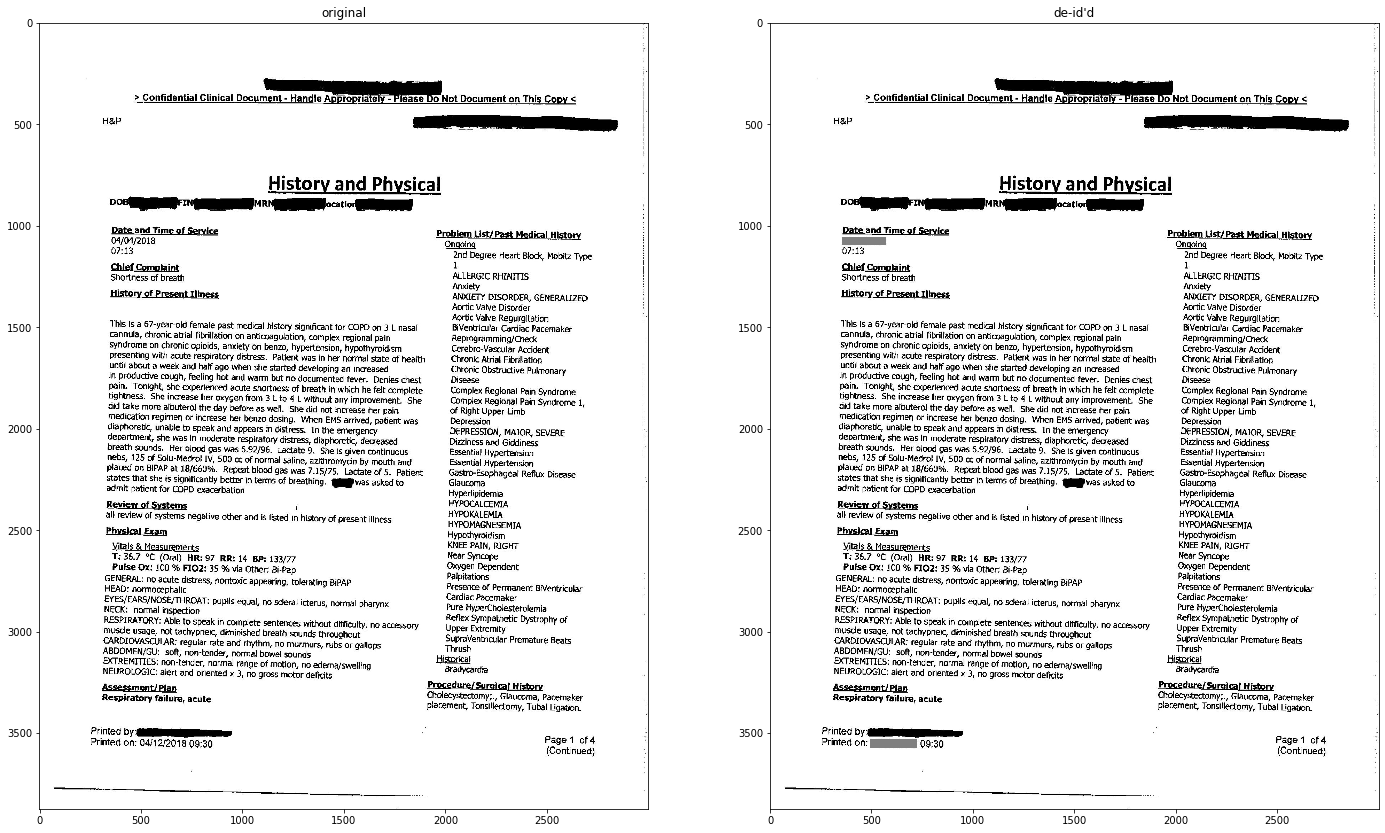

In [0]:
for r in result.select("image_raw", "image_with_regions").collect():
    img_orig = r.image_raw
    img_deid = r.image_with_regions

    img_pil_orig = to_pil_image(img_orig, img_orig.mode)
    img_pil_deid = to_pil_image(img_deid, img_deid.mode)

    plt.figure(figsize=(24,16))
    plt.subplot(1, 2, 1)
    plt.imshow(img_pil_orig, cmap='gray')
    plt.title('original')
    plt.subplot(1, 2, 2)
    plt.imshow(img_pil_deid, cmap='gray')
    plt.title("de-id'd")
    plt.show()

# Dicom to Image

In [0]:
! mkdir dicom
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/dicom/deidentify-brains-front-medical-3.dcm -O /databricks/driver/dicom/dicom_1.dcm
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/dicom/deidentify-medical-1.dcm  -O /databricks/driver/dicom/dicom_2.dcm
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/dicom/deidentify-medical-2.dcm  -O /databricks/driver/dicom/dicom_3.dcm
  
dbutils.fs.cp("file:/databricks/driver/dicom/dicom_1.dcm", "dbfs:/", True)  
dbutils.fs.cp("file:/databricks/driver/dicom/dicom_2.dcm", "dbfs:/", True)  
dbutils.fs.cp("file:/databricks/driver/dicom/dicom_3.dcm", "dbfs:/", True)  


Out[8]: True

In [0]:
dicom_path = 'dbfs:/*.dcm'

# Read dicom file as binary file
dicom_df = spark.read.format("binaryFile").load(dicom_path)

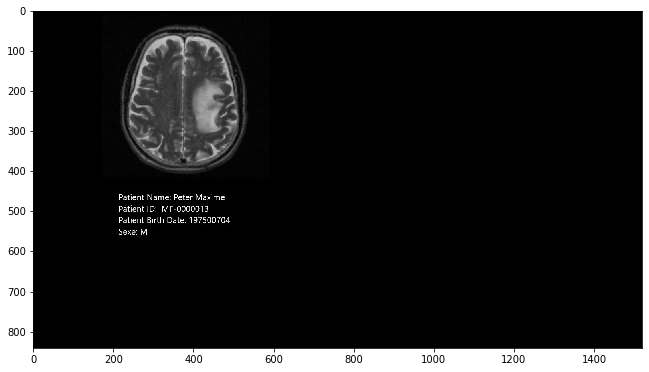

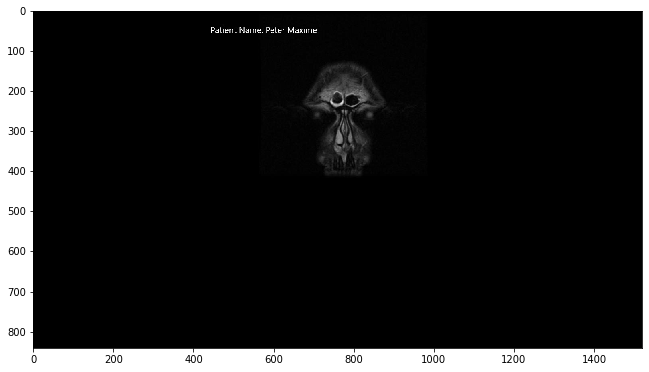

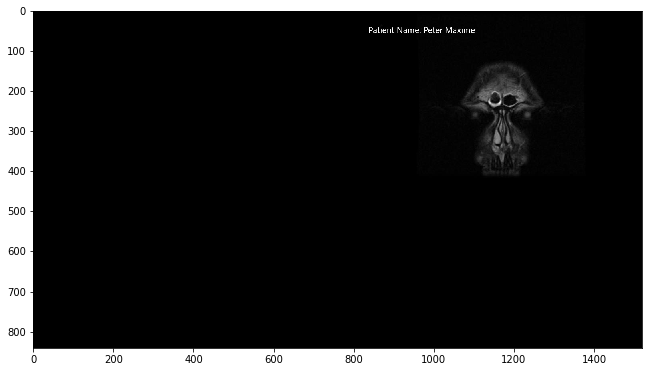

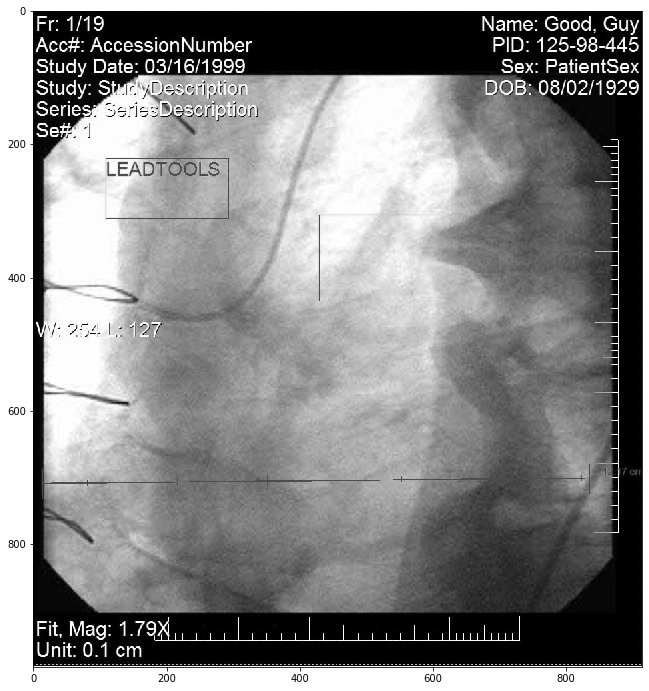

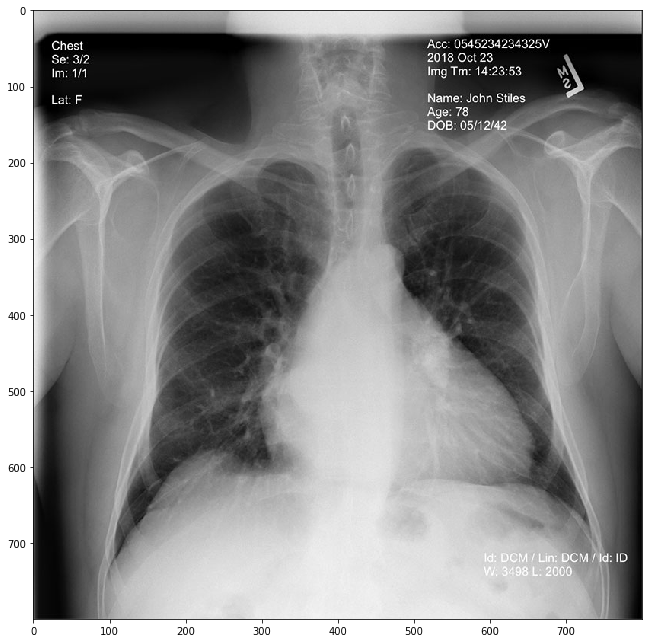

In [0]:
dicomToImage = DicomToImage() \
  .setInputCol("content") \
  .setOutputCol("image") \
  .setMetadataCol("meta")

data = dicomToImage.transform(dicom_df)

for r in data.collect():
    img = r.image
    img_pil = to_pil_image(img, img.mode)
    plt.figure(figsize=(24,16))
    plt.subplot(1, 2, 1)
    plt.imshow(img_pil, cmap='gray')

In [0]:
# Extract text from image
ocr = ImageToText() \
    .setInputCol("image") \
    .setOutputCol("text") \
    .setIgnoreResolution(False) \
    .setOcrParams(["preserve_interword_spaces=0"])


print("\n".join([row.text for row in ocr.transform(data).select("text").collect()]))


Palau
Patient ID: MF-0000013
Patient Birth Date: 197500704
Soa]

 

Pala a aC

 

 

Pala a aC

 

al oat TRS) Name: Good, Guy
(Nee: se Xe) ola elgg o]-18 PID: 125-98-445

Study Date: ore al 999 Sex: PatientSex
_ DOB:,08/02/1929

One)

 

LEADTOOLS

 

 

 

 

 

 

OA yer

2018 Oct 23

Img Tm: 14:23:53
%

Name: John Stiles

## Deidentify PHI on DICOM

https://github.com/JohnSnowLabs/spark-ocr-workshop/blob/master/jupyter/SparkOcrDicomDeIdentification.ipynb

## More example here

https://github.com/JohnSnowLabs/spark-ocr-workshop